task 1

In [114]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from array import array
import datetime
from bs4 import XMLParsedAsHTMLWarning
import warnings

warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

url = "https://news.google.com/rss/search?q=NVIDIA+stock" 

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Referer": "https://news.google.com/rss/search?q=NVIDIA+stock",
    "Connection": "keep-alive",
}

try:
    session = requests.Session()
    session.headers.update(headers)
    # hit homepage first to get cookies/redirects
    session.get("https://news.google.com/rss/search?q=NVIDIA+stock", timeout=10)
    response = session.get(url, timeout=10, allow_redirects=True)
    # debug info if still failing
    if response.status_code == 404:
        print("Got 404 for:", response.url)
        print("Response snippet:", response.text[:500])
        exit()
    response.raise_for_status()
except requests.exceptions.HTTPError:
    print("Request blocked with status code:", response.status_code, "url:", response.url)
    exit()
except Exception as e:
    print("Request error:", e)
    exit()

soup = BeautifulSoup(response.text, "xml")

headlines = []
sources = []
pubdates = []

articles = soup.find_all("item")  # Adjusted class name for Yahoo Finance headlines

for article in articles:
    h = article.find("title")
    headline = h.text.strip() if h else None

    source_tag = article.find("source")
    source = source_tag.text.strip() if source_tag else "Yahoo Finance"

    date_tag = article.find("pubDate")
    pubdate = date_tag.text.strip()[5:17]

    if headline:
        headlines.append(headline)
        sources.append(source)
        pubdates.append(pubdate)

data = {
    "source": sources,
    "headline": headlines,
    "pubdate": pubdates
}

df = pd.DataFrame(data)

df.to_csv("news_raw.csv", index=False)

print("News successfully saved to news_raw.csv")

News successfully saved to news_raw.csv


Task 2: XML Structure Understanding

1.) the tag used to get the article is h3

2.) Each item corresponds to one news article, blog post, update, or announcement

3.) Written in XML with strict, predictable tags.

Uses predefined elements like channel, item, title, link, pubDate.

In [115]:
import pandas as pd
import numpy as np

df = pd.read_csv("news_raw.csv")

df["pubdate"] = pd.to_datetime(df["pubdate"], utc=True).dt.date

df["headline_length"] = df["headline"].astype(str).apply(len)

df.to_csv("news_cleaned.csv", index=False)

print("Cleaned news data saved to news_cleaned.csv")


Cleaned news data saved to news_cleaned.csv


Task 4

In [116]:
import yfinance as yf
import pandas as pd

ticker = "NVDA"

stock = yf.download(ticker, period="10d")

stock_data = stock[["Open", "High", "Low", "Close", "Volume"]]

stock_data.columns = stock_data.columns.get_level_values(0)

stock_data = stock_data.reset_index()

stock_data.to_csv("stock_data.csv", index=False)

print("Stock price data saved to stock_data.csv")



[*********************100%***********************]  1 of 1 completed

Stock price data saved to stock_data.csv


Task 5


Which dates in your news data are non-trading days?
20-12-25,21-12-25,27-12-25,28-12-2025

Why does the stock market not trade on those days?
becuase it was a weekend and the stock market is off on weekends

How many news articles fall on non-trading days?
10 news article were uploaded on NVDA

In [117]:
news_df = pd.read_csv("news_cleaned.csv")
stock_df = pd.read_csv("stock_data.csv")

news_df["pubdate"] = pd.to_datetime(news_df["pubdate"])
stock_df["Date"] = pd.to_datetime(stock_df["Date"])

merged_df = pd.merge(
    news_df,
    stock_df,
    left_on="pubdate",
    right_on="Date",
    how="left"
)

merged_df["is_trading_day"] = merged_df["Open"].notna()
merged_df.to_csv("merged_midterm_data.csv", index=False)


Task 7

News volume per day:
pubdate
2025-11-19     1
2025-12-01     1
2025-12-16     1
2025-12-31     1
2026-01-02     1
2026-01-04     1
2026-01-06     1
2026-01-07     1
2026-01-08     1
2026-01-09     5
2026-01-10     1
2026-01-11     1
2026-01-12     1
2026-01-14     1
2026-01-16     1
2026-01-20     5
2026-01-21     5
2026-01-22    17
2026-01-23    32
2026-01-24    14
2026-01-25     8
dtype: int64


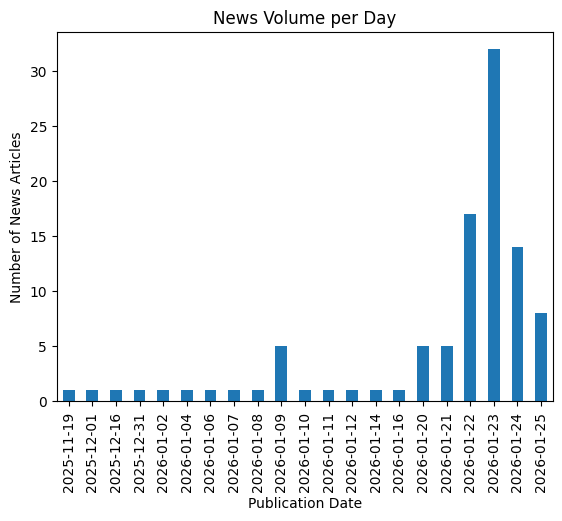

News distribution across sources:
source
The Motley Fool               22
Yahoo Finance                 13
Investor's Business Daily      8
Barron's                       7
Nasdaq                         7
CNBC                           4
TechStock²                     4
Bloomberg                      3
Mint                           3
MarketBeat                     2
simplywall.st                  2
Investing.com                  2
Forbes                         2
MSN                            2
Intellectia AI                 1
Analytics Insight              1
India.Com                      1
MarketWatch                    1
24/7 Wall St.                  1
Trefis                         1
Benzinga                       1
Investing.com India            1
Synopsys                       1
CarbonCredits.com              1
Value Research                 1
Investing.com South Africa     1
scanx.trade                    1
NVIDIA Newsroom                1
NAI500                         1
Ya

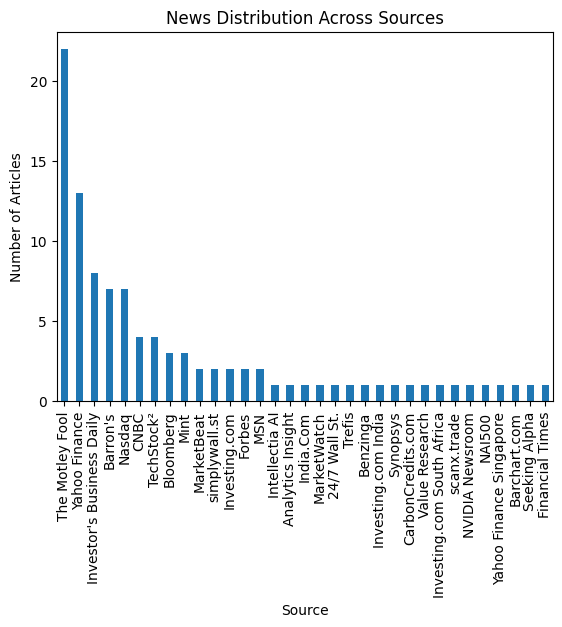

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("news_cleaned.csv")

news_per_day = df.groupby("pubdate").size()

print("News volume per day:")
print(news_per_day)

news_per_day.plot(kind="bar", title="News Volume per Day")
plt.xlabel("Publication Date")
plt.ylabel("Number of News Articles")
plt.show()

news_by_source = df["source"].value_counts()

print("News distribution across sources:")
print(news_by_source)

news_by_source.plot(kind="bar", title="News Distribution Across Sources")
plt.xlabel("Source")
plt.ylabel("Number of Articles")
plt.show()

Sentiment Analysis

In [119]:
import pandas as pd
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert"
)

df = pd.read_csv("merged_midterm_data.csv")

HEADLINE_COLUMN = "headline"
headlines = df[HEADLINE_COLUMN].astype(str).tolist()

results = sentiment_pipeline(headlines)

df["sentiment"] = [r["label"].lower() for r in results]
df["sentiment_confidence"] = [r["score"] for r in results]

df.to_csv("news_with_sentiment.csv", index=False)

print("Sentiment analysis completed. Saved to news_with_sentiment.csv")

Device set to use cpu


Sentiment analysis completed. Saved to news_with_sentiment.csv


Model Training

In [120]:
import pandas as pd

df = pd.read_csv("news_with_sentiment.csv")

df["pubdate"] = pd.to_datetime(df["pubdate"])
df = df.sort_values("pubdate")

df["next_close"] = df["Close"].shift(-1)
df["return_1d"] = (df["next_close"] - df["Close"]) / df["Close"]
df["target"] = (df["return_1d"] > 0).astype(int)

sentiment_map = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

df["sentiment_score"] = (
    df["sentiment"].astype(str).str.lower().map(sentiment_map)
    * df["sentiment_confidence"]
)

df = df.dropna(subset=["target", "sentiment_score"])

df.to_csv("news_with_sentiment_final.csv", index=False)

print("✅ Data preparation complete")

✅ Data preparation complete


In [121]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

df = pd.read_csv("news_with_sentiment_final.csv")

required_cols = [
    "sentiment_score",
    "headline_length",
    "Open",
    "Close",
    "Volume",
    "target"
]

df = df.dropna(subset=required_cols)

X = df[
    [
        "sentiment_score",
        "headline_length",
        "Open",
        "Close",
        "Volume"
    ]
]

y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False
)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:, 1]

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

def evaluate_model(name, y_true, y_pred, y_prob):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob)
    }

results = [
    evaluate_model("Logistic Regression", y_test, lr_pred, lr_prob),
    evaluate_model("Random Forest", y_test, rf_pred, rf_prob)
]

results_df = pd.DataFrame(results)

results_df.to_csv("model_performance_stats.csv", index=False)

print("\n===== MODEL PERFORMANCE =====")
print(results_df)



===== MODEL PERFORMANCE =====
                 model  accuracy  precision  recall  f1_score  roc_auc
0  Logistic Regression       1.0        0.0     0.0       0.0      NaN
1        Random Forest       1.0        0.0     0.0       0.0      NaN


C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Us